# <center>Physics-informed neural network</center>

Se compararán diferentes optimizadores de primer orden utilizando $\tanh$ como función de activación. Para esto, se resolverá la siguiente EDP:

$$
\begin{align}
\Delta u(x,y) & = -x\cos(x) + 2\cos(y) - 2\sin(x) - y\sin(y), & (x,y)\in[-2\pi, 2\pi]\times[-2\pi, 2\pi]\\
u(x, y) & = x\cos(x) + y\sin(y), & (x,y)\in\partial\left([-2\pi, 2\pi]\times[-2\pi, 2\pi]\right)\\
\end{align}
$$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import time

#### Red neuronal

In [2]:
class NeuralNetwork(nn.Module):

    def __init__(self, n_layers, wide):
        super().__init__()
        self.inner_layers = nn.ModuleList([nn.Linear(2 if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        self.last_layer = nn.Linear(wide, 1)
    
    def forward(self, x, y):
        input = torch.cat([x, y], axis=1)
        
        for layer in self.inner_layers:
            input = nn.Tanh()(layer(input))
        input = self.last_layer(input)
        
        return input

In [3]:
def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

#### PDE

In [4]:
cos, sin, pi = torch.cos, torch.sin, torch.pi
x_domain, y_domain = [-2*pi, 2*pi], [-2*pi, 2*pi]

def pde(x, y, net):
    u = net(x, y)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    u_y = derivative(u, y)
    u_yy = derivative(u_y, y)
    return u_xx + u_yy - (-x*cos(x) + 2*cos(y) - 2*sin(x) - y*sin(y))

def boundary_condition(x, y):
    return x*cos(x) + y*sin(y)

def analytical_solution(x, y):
    return x*cos(x) + y*sin(y)

#### Entrenamiento

In [5]:
# Parámetros de entrenamiento:
optimizers_list = ('Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'AdamW', 'SGD')
samples_boundary, samples_collocation = 500, 500
epochs = 5000

In [6]:
# Puntos para el entrenamiento:

x_boundary = torch.empty(samples_boundary, 1).uniform_(*x_domain)
y_boundary = torch.empty(samples_boundary, 1).uniform_(*y_domain)

for n_sample in range(samples_boundary):
    set_var = random.choice([0, 1])
    x_boundary[n_sample, 0] = random.choice(x_domain) if set_var == 0 else random.uniform(*x_domain)
    y_boundary[n_sample, 0] = random.choice(y_domain) if set_var == 1 else random.uniform(*y_domain)

target_boundary = boundary_condition(x_boundary, y_boundary)

# Puntos de colocación:
x_collocation = torch.empty(samples_collocation, 1).uniform_(*x_domain).requires_grad_()
y_collocation = torch.empty(samples_collocation, 1).uniform_(*y_domain).requires_grad_()
target_collocation = torch.zeros(samples_collocation, 1)

# Registro del entrenamiento:
losses = {key: [] for key in optimizers_list}
nets, optimizers = {}, {}

for method in optimizers_list:

    # Modelo y optimizador:
    nets[method] = NeuralNetwork(n_layers=2, wide=100)

    if method == 'SGD':  # para SGD se debe indicar la tasa de aprendizaje.
        optimizers[method] = getattr(optim, method)(nets[method].parameters(), lr=1e-3)
    else:
        optimizers[method] = getattr(optim, method)(nets[method].parameters())

    initial_time = time.time()
    for epoch in range(1, epochs + 1):
        
        optimizers[method].zero_grad()
         
        u_boundary = nets[method](x_boundary, y_boundary)
        loss_boundary = nn.MSELoss()(u_boundary, target_boundary)

        pde_collocation = pde(x_collocation, y_collocation, nets[method])
        loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)
        
        loss = loss_boundary + loss_collocation
        loss.backward()
        
        optimizers[method].step()
        losses[method].append(loss.item())
        
        if epoch % 1000 == 0:
            print(f'{method} | Epoch {epoch} | loss: {losses[method][-1]:.4f}')
    
    training_time = time.strftime('%-M min, %-S sec', time.gmtime(time.time() - initial_time))
    print(f'Training time: {training_time}.', end='\n\n')

Adam | Epoch 1000 | loss: 16.7595
Adam | Epoch 2000 | loss: 7.2767
Adam | Epoch 3000 | loss: 3.0283
Adam | Epoch 4000 | loss: 1.4683
Adam | Epoch 5000 | loss: 0.4833
Training time: 0 min, 9 sec.

RMSprop | Epoch 1000 | loss: 2.2196
RMSprop | Epoch 2000 | loss: 0.6978
RMSprop | Epoch 3000 | loss: 0.6880
RMSprop | Epoch 4000 | loss: 0.6143
RMSprop | Epoch 5000 | loss: 0.5684
Training time: 0 min, 9 sec.

Adadelta | Epoch 1000 | loss: 8.7610
Adadelta | Epoch 2000 | loss: 5.6219
Adadelta | Epoch 3000 | loss: 3.6567
Adadelta | Epoch 4000 | loss: 2.7272
Adadelta | Epoch 5000 | loss: 2.2762
Training time: 0 min, 10 sec.

Adagrad | Epoch 1000 | loss: 19.2344
Adagrad | Epoch 2000 | loss: 15.9679
Adagrad | Epoch 3000 | loss: 13.5532
Adagrad | Epoch 4000 | loss: 11.8454
Adagrad | Epoch 5000 | loss: 10.5364
Training time: 0 min, 10 sec.

AdamW | Epoch 1000 | loss: 15.0480
AdamW | Epoch 2000 | loss: 7.9174
AdamW | Epoch 3000 | loss: 4.8273
AdamW | Epoch 4000 | loss: 2.1254
AdamW | Epoch 5000 | loss

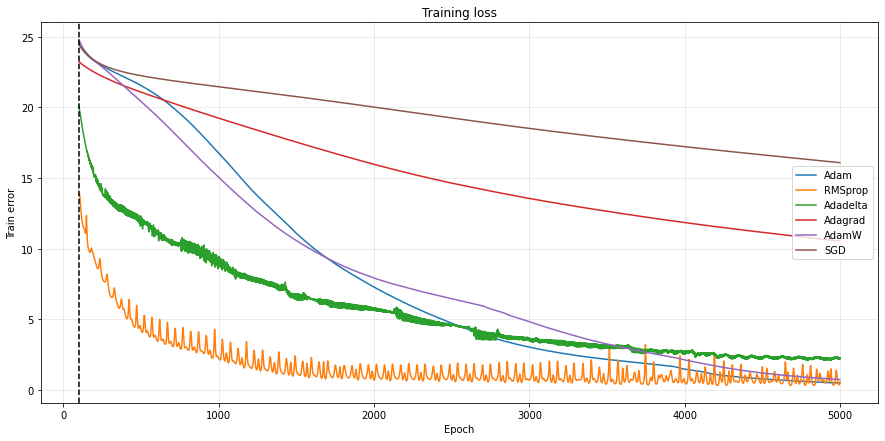

In [7]:
first_epoch = 100

fig = plt.figure(figsize=(15, 7))
for method in optimizers_list:
    epochs_range = torch.arange(first_epoch, epochs + 1, 1)
    plt.plot(epochs_range, losses[method][first_epoch-1:], label=method)
    plt.grid(alpha=0.3)
plt.axvline(first_epoch, linestyle='--', color='k')
plt.legend(loc='center right')
plt.title(f'Training loss')
plt.xlabel('Epoch'); plt.ylabel('Train error')
plt.show()

#### Simulación y comparación con la solución real

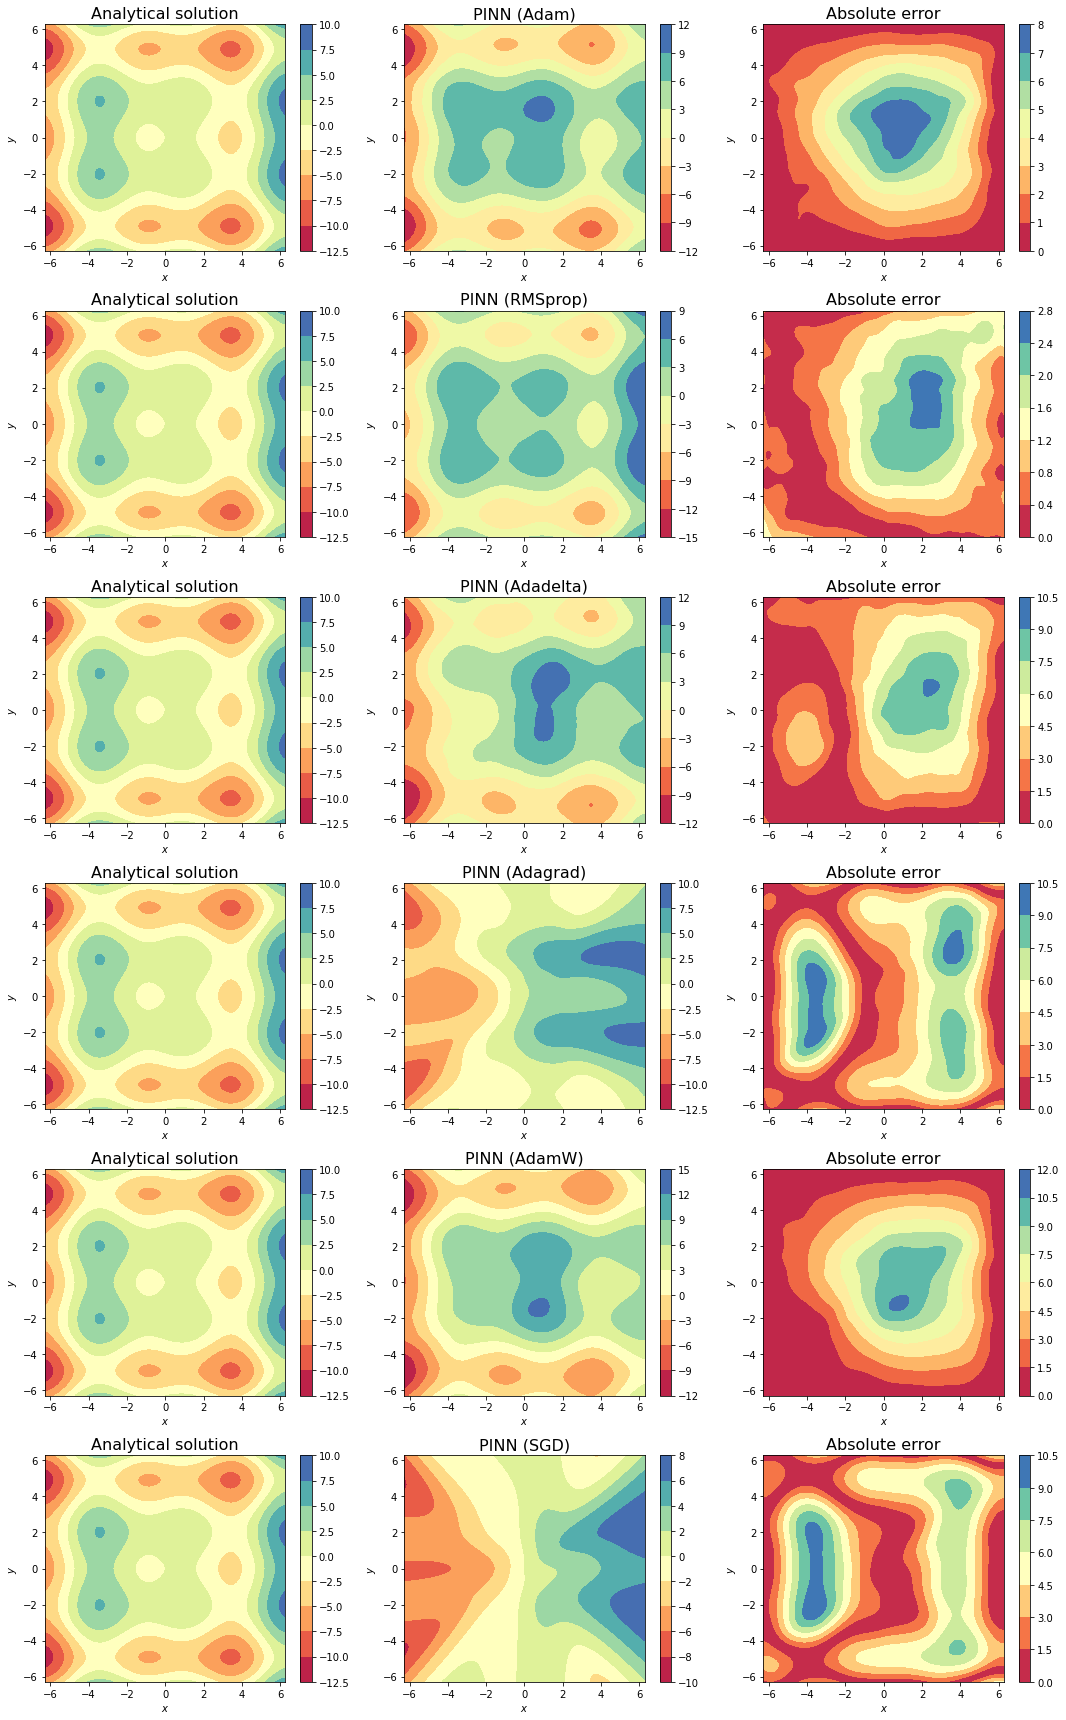

In [8]:
# Puntos del dominio:
x = torch.arange(*x_domain, 1e-2)
y = torch.arange(*y_domain, 1e-2)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
input = grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)

n_plots = len(optimizers_list)
fig = plt.figure(figsize=(15, 4*n_plots))

for i, method in enumerate(optimizers_list):
        
    nets[method].eval()

    # Campos a graficar:
    u_pred = nets[method](*input).detach()
    u_real = analytical_solution(*input)
    error = torch.abs(u_real - u_pred)
    titles = ('Analytical solution', f'PINN ({method})', 'Absolute error')
        
    for j, value in enumerate((u_real, u_pred, error)):    
        
        ax = fig.add_subplot(n_plots, 3, 3*i+j+1)
        simulation = ax.contourf(grid_x, grid_y, value.reshape_as(grid_x), cmap='Spectral')
        plt.colorbar(simulation)
        ax.set_title(titles[j], fontdict={'size': 16})
        ax.set_xlabel('$x$'); ax.set_ylabel('$y$')

plt.tight_layout()
plt.show()